In [1]:
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import cv2
import time
from tqdm import tqdm
import os
import copy
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [2]:
#for training :data normalization & augmentation
#for validation: data normalization

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = r'C:\Users\atmik\Desktop\sem4\DeepFakes\deepfake-detection-challenge\programs\data'
CHECK_POINT_PATH = r'C:\Users\atmik\Desktop\sem4\DeepFakes\deepfake-detection-challenge\train_sample_videos\checkpoint.pth'
#SUBMISSION_FILE = r'C:\Users\atmik\Desktop\sem4\DeepFakes\deepfake-detection-challenge\programs\sample_submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['fake', 'real']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')


['fake', 'real']
Train image size: 5950
Validation image size: 3258


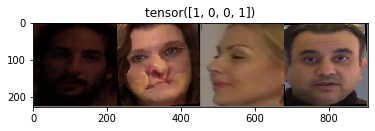

In [3]:
#shows a sample of 4 images, 0 for FAKE and 1 for real

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes)

In [4]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(1,num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('--' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                #if i % 200 == 199:
                    #print('[%d, %d] loss: %.3f' % 
                          #(epoch + 1, i, running_loss / (i * inputs.size(0))))

               
              
              # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found.')
                print(f'New record loss: {epoch_loss}, Previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    #time_elapsed = time.time() - since
    #print('Training completed in {:.0f}m {:.0f}s'.format(
        #time_elapsed // 60, time_elapsed % 60))
              
              
    print('Best val Accuracy: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [5]:
#the imagenet weights downloaded

model_conv = torchvision.models.resnet50(pretrained=True)

In [6]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.3517475223806169, Val accuracy: 0.8933333333333334
Epoch 1/3
--------------------
train Loss: 0.5245 Accuracy: 0.8015
val Loss: 0.5060 Accuracy: 0.8122

Epoch 2/3
--------------------
train Loss: 0.5342 Accuracy: 0.7965
val Loss: 0.5217 Accuracy: 0.7953

Epoch 3/3
--------------------
train Loss: 0.5316 Accuracy: 0.8018
val Loss: 0.5235 Accuracy: 0.8039

Best val Accuracy: 0.8933 Best val loss: 0.3517


In [9]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 40,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.3517475223806169, Val accuracy: 0.8933333333333334
Epoch 1/40
--------------------
train Loss: 0.5305 Accuracy: 0.8034
val Loss: 0.5086 Accuracy: 0.8063

Epoch 2/40
--------------------
train Loss: 0.5278 Accuracy: 0.8035
val Loss: 0.5117 Accuracy: 0.8152

Epoch 3/40
--------------------
train Loss: 0.5336 Accuracy: 0.7988
val Loss: 0.5334 Accuracy: 0.7891

Epoch 4/40
--------------------
train Loss: 0.5241 Accuracy: 0.8045
val Loss: 0.5123 Accuracy: 0.8066

Epoch 5/40
--------------------
train Loss: 0.5370 Accuracy: 0.8003
val Loss: 0.5044 Accuracy: 0.8211

Epoch 6/40
--------------------
train Loss: 0.5275 Accuracy: 0.7971
val Loss: 0.5031 Accuracy: 0.8229

Epoch 7/40
--------------------
train Loss: 0.5311 Accuracy: 0.7998
val Loss: 0.4995 Accuracy: 0.8235

Epoch 8/40
--------------------
train Loss: 0.5416 Accuracy: 0.7992
val Loss: 0.5076 Accuracy: 0.8183

Epoch 9/40
--------------------
train Loss: 0.5239 Accuracy: 0.8039
val Loss: 0.5099 Accuracy: 

KeyboardInterrupt: 

In [10]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 20,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.3517475223806169, Val accuracy: 0.8933333333333334
Epoch 1/20
--------------------
train Loss: 0.4721 Accuracy: 0.8426
val Loss: 0.5629 Accuracy: 0.7548

Epoch 2/20
--------------------
train Loss: 0.4705 Accuracy: 0.8376
val Loss: 0.5214 Accuracy: 0.8144

Epoch 3/20
--------------------
train Loss: 0.4740 Accuracy: 0.8381
val Loss: 0.5298 Accuracy: 0.7954

Epoch 4/20
--------------------
train Loss: 0.4694 Accuracy: 0.8414
val Loss: 0.5293 Accuracy: 0.7808

Epoch 5/20
--------------------
train Loss: 0.4644 Accuracy: 0.8357
val Loss: 0.5482 Accuracy: 0.7561

Epoch 6/20
--------------------
train Loss: 0.4593 Accuracy: 0.8409
val Loss: 0.5302 Accuracy: 0.7954

Epoch 7/20
--------------------
train Loss: 0.4738 Accuracy: 0.8402
val Loss: 0.5365 Accuracy: 0.7746

Epoch 8/20
--------------------
train Loss: 0.4645 Accuracy: 0.8369
val Loss: 0.5692 Accuracy: 0.7397

Epoch 9/20
--------------------
train Loss: 0.4748 Accuracy: 0.8360
val Loss: 0.5491 Accuracy: 

KeyboardInterrupt: 

In [7]:
#now, trying to train the last few layers of pretrained model and seeing if accuracy changes:


#NOTE: after training on gpu, loss actually increased slightly.

In [19]:
for param in model_conv.parameters():
    param.requires_grad = False
# param = false,we only want to train last layer

model_conv = model_conv.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [15]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded!")
except:
    checkpoint = None
    print("checkpoint is not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded!
Val loss: 0.3517475223806169, Val accuracy: 0.8933333333333334
Epoch 1/3
--------------------


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [16]:
checkpoint = torch.load(CHECK_POINT_PATH)
print("checkpoint loaded!")
print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')

checkpoint loaded!
Val loss: 0.3517475223806169, Val accuracy: 0.8933333333333334


In [28]:
#takes PIL image as input. Outputs a tensor. Normalization done same as what's done for validation images.

def applyTransforms(inp):
    outp = transforms.functional.resize(inp, [224,224])
    outp = transforms.functional.to_tensor(outp)
    outp = transforms.functional.normalize(outp, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return outp

In [12]:
#trying to test fake/real percentages of a single frame. (comment out later)

img = Image.open(r'C:\Users\dhanya\deepfakes\deepfake-detection-challenge\programs\tests\image0.jpg')
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dhanya\\deepfakes\\deepfake-detection-challenge\\programs\\tests\\image0.jpg'

In [14]:
imageTensor = applyTransforms(img)
minibatch = torch.stack([imageTensor])
model_conv(minibatch)


NameError: name 'img' is not defined

In [15]:
#softmax function to determine the probability of fake/real

softMax = nn.Softmax(dim = 1)
predic = softMax(model_conv(minibatch))
predic

NameError: name 'minibatch' is not defined

In [16]:
print(predic[0,0].item())    #fake prob
print(predic[0,1].item())    #real prob

NameError: name 'predic' is not defined

In [17]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++

#myVideo is a function to test the fake/real probability of a video. input parameter is path to the video

In [29]:
def myVideo(file_name,model):
    mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device=device)
    # Load video
    v_cap = cv2.VideoCapture(file_name)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Loop through video, taking some no of frames to form a batch   (here, every 50th frame)
    frames = []
    for i in tqdm(range(v_len)):
    
        # Load frame
        success = v_cap.grab()
        if i % 50 == 0:
            success, frame = v_cap.retrieve()
        else:
            continue
        if not success:
            continue
        
        # Add to batch
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(Image.fromarray(frame))



    #detect faces in frames &  saving frames to file
    f=r"C:\Users\atmik\Desktop\sem4\DeepFakes\dfdc_train_part_03\programs\testFrames\\"
    frames_paths = [f+'image' + str(i) +'.jpg' for i in range(len(frames))]
    faces = mtcnn(frames,save_path=frames_paths)
    
    path=os.listdir(r'C:\Users\atmik\Desktop\sem4\DeepFakes\dfdc_train_part_03\programs\testFrames')
    vals_f=[]
    vals_r=[]
    for x in path:
        img = Image.open(r'C:\Users\atmik\Desktop\sem4\DeepFakes\dfdc_train_part_03\programs\testFrames\\' + x)
        imageTensor = applyTransforms(img)
        minibatch = torch.stack([imageTensor])
        #model_conv(minibatch)
        softMax = nn.Softmax(dim = 1)
        preds = softMax(model(minibatch))
        vals_f.append(preds[0,0].item())
        vals_r.append(preds[0,1].item())
        
    
    for i in vals_f:
        print(i)
    
    av=sum(vals_f)/len(path)
    print("average probability of fakeness:",av)
    print('Percentage of fakeness: {:.4f}'.format(av*100))
    
    av=sum(vals_r)/len(path)
    print("average probability of realness:",av)
    print('Percentage of realness: {:.4f}'.format(av*100))  


In [30]:
#checking video's label in the metadata file

In [31]:
import json
fp=open(r'C:\Users\atmik\Desktop\sem4\DeepFakes\videosandmetadatafile\metadata.json',)
data=json.load(fp)
path='apscwnwndu.mp4'
print(data[path]['label'])
fp.close()

FAKE


In [32]:
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
def testing(name,model):
    
    #import os
    f=r"C:\Users\atmik\Desktop\sem4\DeepFakes\dfdc_train_part_03\programs\testFrames"
    reqd=os.listdir(f)
    
    if len(reqd)!=0:
        for i in reqd:
            os.remove(f+"\\"+i)
    
    path=r'C:\Users\atmik\Desktop\sem4\DeepFakes\videosandmetadatafile\\'+ name
    myVideo(path,model)

    import json
    fp=open(r'C:\Users\atmik\Desktop\sem4\DeepFakes\videosandmetadatafile\metadata.json',)
    data=json.load(fp)
    path=name
    print('The true label is:',data[path]['label'])
    fp.close()
    

In [34]:
testing('apscwnwndu.mp4',model_conv)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\atmik\\Desktop\\sem4\\DeepFakes\\dfdc_train_part_03\\programs\\testFrames\\image0.jpg'

In [35]:
testing('nliofvksed.mp4',model_conv)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\atmik\\Desktop\\sem4\\DeepFakes\\dfdc_train_part_03\\programs\\testFrames\\image0.jpg'

In [43]:
testing('dehhyjdoal.mp4',model_conv)

100%|██████████| 300/300 [00:00<00:00, 316.31it/s]


0.619954526424408
0.6536960601806641
0.617196261882782
0.5513416528701782
0.6847761273384094
0.6149329543113708
average probability of fakeness: 0.6236495971679688
Percentage of fakeness: 62.3650
average probability of realness: 0.37635041773319244
Percentage of realness: 37.6350
The true label is: FAKE


In [61]:

testing('isenrfjdku.mp4',model_conv)

100%|██████████| 300/300 [00:01<00:00, 230.15it/s]


0.5082512497901917
0.599094033241272
0.505517840385437
0.6521589159965515
0.6756457090377808
0.5339475870132446
0.6937153339385986
0.5051093697547913
0.6199946999549866
0.48951348662376404
0.6140789985656738
0.6122612357139587
0.6421938538551331
0.5767349004745483
average probability of fakeness: 0.5877298010247094
Percentage of fakeness: 58.7730
average probability of realness: 0.4122701904603413
Percentage of realness: 41.2270
The true label is: FAKE


In [44]:
testing('exnxonosso.mp4',model_conv)

100%|██████████| 300/300 [00:01<00:00, 218.45it/s]


0.4983070492744446
0.4849098026752472
0.5355455875396729
0.5506449937820435
0.4994129240512848
0.5418139100074768
average probability of fakeness: 0.5184390445550283
Percentage of fakeness: 51.8439
average probability of realness: 0.48156097531318665
Percentage of realness: 48.1561
The true label is: FAKE


In [46]:
testing('geturetbpy.mp4',model_conv)

100%|██████████| 300/300 [00:01<00:00, 199.87it/s]


0.709837794303894
0.705707311630249
0.680909276008606
0.7349546551704407
0.7436955571174622
0.681580662727356
average probability of fakeness: 0.7094475428263346
Percentage of fakeness: 70.9448
average probability of realness: 0.2905524472395579
Percentage of realness: 29.0552
The true label is: REAL


In [47]:
testing('fbqwomdehr.mp4',model_conv)

100%|██████████| 300/300 [00:02<00:00, 127.30it/s]


0.5581961870193481
0.6729723811149597
0.5352914333343506
0.6510912775993347
0.5445469617843628
0.6212760210037231
0.5534836053848267
0.621442973613739
0.534888744354248
0.5872836112976074
0.5381734371185303
0.599280834197998
average probability of fakeness: 0.5848272889852524
Percentage of fakeness: 58.4827
average probability of realness: 0.41517270853122074
Percentage of realness: 41.5173
The true label is: FAKE


In [1]:
testing('hsaafwdtoj.mp4',model_conv)

NameError: name 'testing' is not defined